In [401]:
import pandas as pd
import numpy as np
import sklearn as sk
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
import pickle
from sklearn.tree import export_graphviz
from dtreeviz.trees import dtreeviz
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import streamlit as st

In [370]:
train = pd.read_csv('train.csv')

In [371]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [372]:
test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [373]:
train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [374]:
train.shape

(614, 13)

In [375]:
train['Loan_Status'].value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

In [376]:
train.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [377]:
train = train.dropna()

In [378]:
train.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

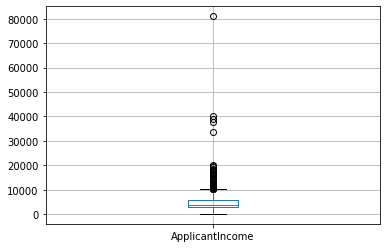

In [379]:
ApplicantIncome = train.boxplot(column = 'ApplicantIncome')
ApplicantIncome

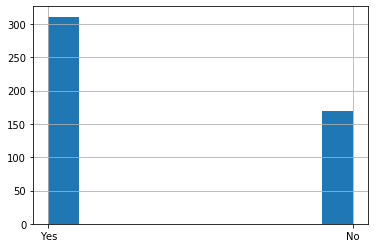

In [380]:
Married = train['Married'].hist()
Married

In [381]:
Property_Area = pd.crosstab(train['Property_Area'], train['Loan_Status'], margins = True)
Property_Area

Loan_Status,N,Y,All
Property_Area,,,
Rural,54,85,139
Semiurban,42,149,191
Urban,52,98,150
All,148,332,480


In [382]:
Married = pd.crosstab(train['Married'], train['Loan_Status'], margins = True)
Married

Loan_Status,N,Y,All
Married,,,
No,64,105,169
Yes,84,227,311
All,148,332,480


In [383]:
CreditHistory = pd.crosstab(train['Credit_History'], train['Loan_Status'], margins = True)
CreditHistory

Loan_Status,N,Y,All
Credit_History,,,
0.0,63,7,70
1.0,85,325,410
All,148,332,480


In [384]:
train['TotalApplicantIncome'] = train['ApplicantIncome'] + train['ApplicantIncome']
train

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalApplicantIncome
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,9166
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,6000
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,5166
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,12000
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y,10834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y,5800
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y,8212
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y,16144
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y,15166


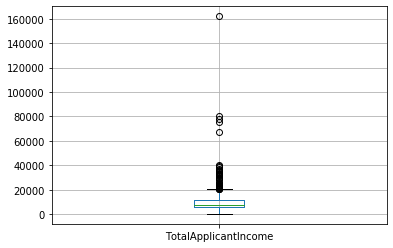

In [385]:
TotalAppInc = train.boxplot('TotalApplicantIncome')
TotalAppInc

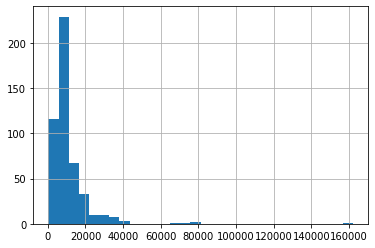

In [386]:
TotalAppInc_hist = train['TotalApplicantIncome'].hist(bins = 30)
TotalAppInc_hist

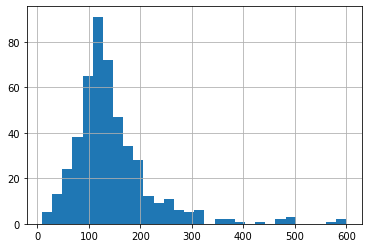

In [387]:
LoanAmount = train['LoanAmount'].hist(bins = 30)
LoanAmount

In [388]:
gender_dummies = pd.get_dummies(train['Gender'])
train = pd.concat((train, gender_dummies), axis = 1)
train = train.drop(['Gender'], axis = 1)
train = train.drop(['Male'], axis = 1)
train = train.rename(columns = {'Female' : 'Gender'})
train

,Loan_ID,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalApplicantIncome,Gender
1,LP001003,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,9166,0
2,LP001005,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,6000,0
3,LP001006,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,5166,0
4,LP001008,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,12000,0
5,LP001011,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y,10834,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y,5800,1
610,LP002979,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y,8212,0
611,LP002983,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y,16144,0
612,LP002984,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y,15166,0


In [389]:
married_dummies = pd.get_dummies(train['Married'])
train = pd.concat((train, married_dummies), axis = 1)
train = train.drop(['Married'], axis = 1)
train = train.drop(['No'], axis = 1)
train = train.rename(columns = {'Yes' : 'Married'})
train

,Loan_ID,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalApplicantIncome,Gender,Married
1,LP001003,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,9166,0,1
2,LP001005,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,6000,0,1
3,LP001006,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,5166,0,1
4,LP001008,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,12000,0,0
5,LP001011,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y,10834,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y,5800,1,0
610,LP002979,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y,8212,0,1
611,LP002983,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y,16144,0,1
612,LP002984,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y,15166,0,1


In [390]:
LoanStatus_dummies = pd.get_dummies(train['Loan_Status'])
train = pd.concat((train, LoanStatus_dummies), axis = 1)
train = train.drop(['Loan_Status'], axis = 1)
train = train.drop(['N'], axis = 1)
train = train.rename(columns = {'Y' : 'Loan_Approved'})
train

,Loan_ID,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,TotalApplicantIncome,Gender,Married,Loan_Approved
1,LP001003,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,9166,0,1,0
2,LP001005,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,6000,0,1,1
3,LP001006,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,5166,0,1,1
4,LP001008,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,12000,0,0,1
5,LP001011,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,10834,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,5800,1,0,1
610,LP002979,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,8212,0,1,1
611,LP002983,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,16144,0,1,1
612,LP002984,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,15166,0,1,1


In [391]:
train.astype({'Credit_History' : int})

,Loan_ID,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,TotalApplicantIncome,Gender,Married,Loan_Approved
1,LP001003,1,Graduate,No,4583,1508.0,128.0,360.0,1,Rural,9166,0,1,0
2,LP001005,0,Graduate,Yes,3000,0.0,66.0,360.0,1,Urban,6000,0,1,1
3,LP001006,0,Not Graduate,No,2583,2358.0,120.0,360.0,1,Urban,5166,0,1,1
4,LP001008,0,Graduate,No,6000,0.0,141.0,360.0,1,Urban,12000,0,0,1
5,LP001011,2,Graduate,Yes,5417,4196.0,267.0,360.0,1,Urban,10834,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,0,Graduate,No,2900,0.0,71.0,360.0,1,Rural,5800,1,0,1
610,LP002979,3+,Graduate,No,4106,0.0,40.0,180.0,1,Rural,8212,0,1,1
611,LP002983,1,Graduate,No,8072,240.0,253.0,360.0,1,Urban,16144,0,1,1
612,LP002984,2,Graduate,No,7583,0.0,187.0,360.0,1,Urban,15166,0,1,1


In [392]:
train[train['Married'] == 1].shape[0] 

311

In [393]:
#independent variables
features = ['Gender', 'Married', 'TotalApplicantIncome', 'LoanAmount', 'Credit_History']
X = train[features]
#dependent variables
dependent = 'Loan_Approved'
y = train[dependent]
X.shape, y.shape

#split dataset into train (80%) and test (20%), shuffle observations
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 10, shuffle = True)

#build random forest model, limit max depth to avoid overfitting
model = RandomForestClassifier(max_depth=4, random_state = 10, n_estimators = 100) 
model.fit(x_train, y_train)

#Accuracy for testing data
pred_test = model.predict(x_test)
accuracy_test = accuracy_score(y_test,pred_test)

#Accuracy for training data
pred_train = model.predict(x_train)
accuracy_train = accuracy_score(y_train,pred_train)

print('Accuracy Train:',accuracy_train,'Accuracy Test:',accuracy_test)

Accuracy Train: 0.8203125 Accuracy Test: 0.8020833333333334


In [394]:
inputs = [[1, 1, 0, 71, 0]]

pred_inputs = model.predict(inputs)
pred_inputs[0]

0

In [395]:
confusion_matrix = confusion_matrix(y_test, pred_test)
confusion_matrix

array([[10, 19],
       [ 0, 67]])

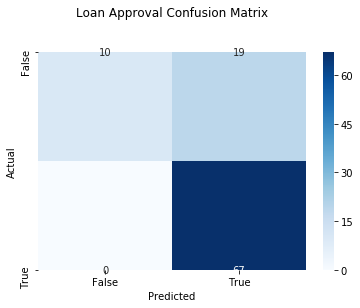

In [396]:
ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt = '')

ax.set_title('Loan Approval Confusion Matrix\n\n');
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [397]:
estimator = model.estimators_[50]
estimator
model.estimators_[50].tree_.max_depth

4

In [398]:
#tree = sk.tree.plot_tree(estimator, feature_names=features, filled=True, fontsize = 5)
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (32,20), dpi=500)
sk.tree.plot_tree(estimator, filled=True, fontsize = 10, feature_names=features, class_names = True)
fig.savefig('tree.png')

In [402]:
# pickle_out = open("Loan_Approval_Prediction.pkl", mode = "wb") 
# pickle.dump(model, pickle_out) 
# pickle_out.close()

In [403]:
# model.fit(X_train, Y_train)
# # save the model to disk
# filename = 'finalized_model.sav'
# pickle.dump(model, open(filename, 'wb'))
 
# # load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)

In [79]:
#https://towardsdatascience.com/visualizing-decision-trees-with-python-scikit-learn-graphviz-matplotlib-1c50b4aa68dc